In [228]:
import pandas as pd
type = "text"

type_train_df_x = pd.read_parquet(f"df/{type}_train_df_x.gzip")
type_test_df_x = pd.read_parquet(f"df/{type}_test_df_x.gzip")

type_train_df_y = pd.read_parquet(f"df/{type}_train_df_y.gzip")
type_test_df_y = pd.read_parquet(f"df/{type}_test_df_y.gzip")
joined_train_df = pd.concat([type_train_df_x, type_train_df_y], axis=1).reset_index(drop=True)
joined_test_df = pd.concat([type_test_df_x, type_test_df_y], axis=1).reset_index(drop=True)

joined = pd.concat([joined_train_df, joined_test_df], axis=0).reset_index(drop=True)

In [187]:
import joblib
cate_features = joblib.load(f"results/ate_cate/models/media_bias_{type}_ate_models.pkl")

In [188]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


# ────────────────────────────────────────────────────────────────────────────
#  1.  Mediator-model accuracy & confusion matrix
# ────────────────────────────────────────────────────────────────────────────
def mediator_confusion(df_slice: pd.DataFrame,
                       mediator_col: str,
                       model_m,
                       treat_col: str,
                       topic_cols: list[str],
                       window_name: str = "current window"):
    """
    Evaluates the RF mediator model on the same slice used for NIE/NDE.

    Parameters
    ----------
    df_slice     : DataFrame after topic filtering (n ≈ 230)
    mediator_col : name of the mediator sentiment column (−1/0/+1)
    model_m      : fitted RandomForestClassifier  M ~ (T , W)
    treat_col    : treatment-sentiment column (included in RF features)
    topic_cols   : list of topic columns used as W in the RF
    """
    # predictors = W + T  in exactly the order used in .fit
    X_rf = pd.concat(
        [df_slice[topic_cols].reset_index(drop=True),
         df_slice[treat_col].astype(int).rename("T").reset_index(drop=True)],
        axis=1
    )
    y_true = df_slice[mediator_col].astype(int).to_numpy()
    y_pred = model_m.predict(X_rf)

    acc = (y_true == y_pred).mean() * 100
    print(f"[{window_name}] mediator RF accuracy = {acc:.1f} %")

    cm = confusion_matrix(y_true, y_pred, labels=[-1, 0, +1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[-1, 0, +1], yticklabels=[-1, 0, +1])
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"{window_name}: {mediator_col} confusion matrix")
    plt.tight_layout(); plt.show()

    print(classification_report(y_true, y_pred, labels=[-1, 0, +1]))



# ────────────────────────────────────────────────────────────────────────────
#  2.  Overlap table 📊   counts for every (T , M) combination
# ────────────────────────────────────────────────────────────────────────────
def tm_overlap(df_slice: pd.DataFrame,
               treat_col: str,
               mediator_col: str,
               window_name: str = "current window"):
    tab = pd.crosstab(df_slice[treat_col], df_slice[mediator_col])\
            .reindex(index=[-1,0,+1], columns=[-1,0,+1], fill_value=0)
    print(f"\n[{window_name}] counts per (T , M) cell:")
    display(tab)

    sparse = tab < 5
    if sparse.any().any():
        print("Sparse cells (<5) ▼")
        display(tab.where(sparse).fillna(""))
    else:
        print("All nine cells have ≥ 5 observations.")
    return tab



# ────────────────────────────────────────────────────────────────────────────
#  3.  Consistency check TE ≈ NDE + NIE
# ────────────────────────────────────────────────────────────────────────────
def te_consistency(result_df: pd.DataFrame,
                   tol_multiplier: float = 1.0,
                   window_name: str = "current window"):
    """
    Flags bias classes where TE differs from NDE+NIE by more than
    `tol_multiplier` × (upper TE CI − lower TE CI)/2.
    """
    mismatches = []
    for _, row in result_df.iterrows():
        te   = row["mean_TE"]
        nde  = row["mean_NDE"]
        nie  = row["mean_NIE"]
        se   = (row["ci_high_TE"] - row["ci_low_TE"]) / 2
        diff = te - (nde + nie)
        ok   = abs(diff) <= tol_multiplier * se
        status = "✔︎" if ok else "✖︎"
        mismatches.append((row["class"], diff, status))

    print(f"\n[{window_name}] TE vs NDE+NIE consistency:")
    for cls, d, s in mismatches:
        print(f"  class {cls}:  diff = {d:+.4f}   {s}")

    return mismatches


In [189]:
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier

def estimate_nde_nie_te_for_mediator_from_df(
        df_all       : pd.DataFrame,
        treatment_col: str,            # e.g. 'sentiment_Media_Bias'
        mediator_col : str,            # e.g. 'sentiment_Donald_Trump'
        models       : dict,           # {bias_class : fitted CausalForestDML}
        t0           : int,            # control  level (0)
        t1           : int             # treated level (-1 or +1)
):
    """
    Consistent manual calculation of TE, NDE, NIE:
        TE  = Y(t1,M1) − Y(t0,M0)
        NDE = Y(t1,M0) − Y(t0,M0)
        NIE = Y(t1,M1) − Y(t1,M0)
    The identities hold because all three contrasts are derived from the same
    two counter-factual worlds (t0,M0) and (t1,M1).
    """

    # ── filter rows where both topics are present ──────────────────────
    df = df_all[
        df_all[treatment_col.replace("sentiment", "topic")] &
        df_all[mediator_col .replace("sentiment", "topic")]
    ].copy()

    sentiment_cols = [c for c in df.columns if c.startswith("sentiment")]
    topic_cols     = [c for c in df.columns if c.startswith("topic")]

    T  = df[treatment_col].astype(int)
    W  = df[topic_cols]                             # confounders in RF
    X0 = df[[c for c in sentiment_cols if c != treatment_col]].copy()

    # ── mediator model M ~ (T , W) ─────────────────────────────────────
    rf_m = RandomForestClassifier(n_estimators=300, random_state=42)
    rf_m.fit(pd.concat([W, T.rename("T")], axis=1), df[mediator_col])

    W_T0 = pd.concat([W, pd.Series(t0, index=W.index, name="T")], axis=1)
    W_T1 = pd.concat([W, pd.Series(t1, index=W.index, name="T")], axis=1)
    M0   = rf_m.predict(W_T0)   # mediator under T = t0
    M1   = rf_m.predict(W_T1)   # mediator under T = t1

    # covariate frames for M0 and M1
    X_M0 = X0.copy();  X_M0[mediator_col] = M0
    X_M1 = X0.copy();  X_M1[mediator_col] = M1

    n = len(df)
    def ci(arr):
        mu  = arr.mean()
        se  = arr.std(ddof=1) / np.sqrt(n)
        return mu, mu - 1.96*se, mu + 1.96*se

    records = []

    for cls, forest in models.items():
        # NDE: change T, hold M = M0
        nde_vals = forest.effect(
            X_M0.to_numpy(),
            T0=np.full(n, t0),
            T1=np.full(n, t1)
        )

        # NIE: change M (X-frame) at fixed T = t1
        eff_M1 = forest.effect(
            X_M1.to_numpy(),
            T0=np.full(n, t1), T1=np.full(n, t1)
        )            # = 0 but keeps call symmetric
        eff_M0 = forest.effect(
            X_M0.to_numpy(),
            T0=np.full(n, t1), T1=np.full(n, t1)
        )
        nie_vals = eff_M1 - eff_M0     # = 0 - 0 + design diff in X → NIE

        # Total effect: swap both T and M simultaneously
        te_vals = forest.effect(
            X_M1.to_numpy(),
            T0=np.full(n, t0),
            T1=np.full(n, t1)
        )

        # confidence intervals
        m_te,  lo_te,  hi_te  = ci(te_vals)
        m_nde, lo_nde, hi_nde = ci(nde_vals)
        m_nie, lo_nie, hi_nie = ci(nie_vals)

        records.append({'class': cls,
            'mean_TE': m_te,  
            'ci_low_TE'  : lo_te,
            'ci_high_TE' : hi_te,
            'mean_NDE' : m_nde, 'ci_low_NDE' : lo_nde, 'ci_high_NDE' : hi_nde,
            'mean_NIE': m_nie, 'ci_low_NIE' : lo_nie, 'ci_high_NIE' : hi_nie
        })

    return (pd.DataFrame(records), rf_m)


In [199]:
import numpy as np, pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer


def estimate_nde_nie_te_for_mediator_from_df(
    df_all       : pd.DataFrame,
    treatment_col: str,        # e.g. 'sentiment_Media_Bias'
    mediator_col : str,        # e.g. 'sentiment_Donald_Trump'
    t0           : int,        # baseline   (0)
    t1           : int         # treatment  (+1 or -1)
) -> pd.DataFrame:
    """
    • Outcome model = L2-regularised binary logistic (one-vs-rest).
    • Mediator model = random-forest classifier  M ~

(T,W).  
    • Returns a dataframe with TE, NDE, NIE (+95 % CIs) and, because the
      same two potential-outcome worlds are used, TE == NDE + NIE up to
      floating-point error.
    """

    outcome_col = "int_bias"          # 0 = left, 1 = centre, 2 = right
    # ───────────────────────────────────────────────────────── topic filter
    df = df_all.copy()
    df = df[
        df[treatment_col.replace("sentiment", "topic")] &
        df[mediator_col .replace("sentiment", "topic")]
    ].reset_index(drop=True)

    # Split columns
    topic_cols     = [c for c in df.columns if c.startswith("topic")]
    sentiment_cols = [c for c in df.columns if c.startswith("sentiment")]

    # Variables
    T  = df[treatment_col].astype(int)
    W  = df[topic_cols]

    # ───────────────────────────────────────────────────────── mediator RF
    rf_m = RandomForestClassifier(
        n_estimators=300, max_depth=None, random_state=42
    )
    rf_m.fit(pd.concat([W, T.rename("T")], axis=1), df[mediator_col])

    W_T0 = pd.concat([W, pd.Series(t0, index=W.index, name="T")], axis=1)
    W_T1 = pd.concat([W, pd.Series(t1, index=W.index, name="T")], axis=1)
    M0   = rf_m.predict(W_T0)          # mediator under T=t0
    M1   = rf_m.predict(W_T1)          # mediator under T=t1

    # ───────────────────────────────────────────────────────── design X
    #  Minimal bounded features:  T  +  M  +  T×M  +  topics as W
    X_base = pd.DataFrame({
        "T"    : T,
        "M"    : df[mediator_col].astype(int),
        "TxM"  : T * df[mediator_col].astype(int)
    }).join(W.astype(int))

    # Potential-outcome frames
    X_T0M0 = X_base.copy()
    X_T0M0["T"]   = t0;  X_T0M0["M"] = M0;  X_T0M0["TxM"] = t0 * M0

    X_T1M0 = X_base.copy()
    X_T1M0["T"]   = t1;  X_T1M0["M"] = M0;  X_T1M0["TxM"] = t1 * M0

    X_T1M1 = X_base.copy()
    X_T1M1["T"]   = t1;  X_T1M1["M"] = M1;  X_T1M1["TxM"] = t1 * M1

    # ───────────────────────────────────────────────────────── outcome models
    lb          = LabelBinarizer()
    Y_multi     = lb.fit_transform(df[outcome_col])
    bias_labels = lb.classes_
    n           = len(df)

    def ci(arr):
        m  = arr.mean()
        se = arr.std(ddof=1) / np.sqrt(n)
        return m, m - 1.96*se, m + 1.96*se

    records = []

    for k, cls in enumerate(bias_labels):
        y_bin = Y_multi[:, k]

        # logistic with L2 (“ridge”) regularisation
        logit = LogisticRegression(
            penalty="l2", C=1.0, solver="lbfgs", max_iter=600
        ).fit(X_base, y_bin)

        # Probabilities in the three worlds
        p_T0M0 = logit.predict_proba(X_T0M0)[:, 1]
        p_T1M0 = logit.predict_proba(X_T1M0)[:, 1]
        p_T1M1 = logit.predict_proba(X_T1M1)[:, 1]

        nde_vals = p_T1M0 - p_T0M0                # direct path
        nie_vals = p_T1M1 - p_T1M0                # mediator path
        te_vals  = p_T1M1 - p_T0M0                # total path

        m_te, lo_te, hi_te   = ci(te_vals)
        m_nde,lo_nde,hi_nde  = ci(nde_vals)
        m_nie,lo_nie,hi_nie  = ci(nie_vals)

        records.append({
            "class"      : cls,
            "mean_TE"    : m_te,  "ci_low_TE"  : lo_te,  "ci_high_TE"  : hi_te,
            "mean_NDE"   : m_nde, "ci_low_NDE" : lo_nde, "ci_high_NDE" : hi_nde,
            "mean_NIE"   : m_nie, "ci_low_NIE" : lo_nie, "ci_high_NIE" : hi_nie
        })

    return (pd.DataFrame(records), rf_m)


In [229]:
# --- run the original NIE/NDE estimator ---
result_df, model_m = estimate_nde_nie_te_for_mediator_from_df(
    df_all        = joined,
    treatment_col = "sentiment Media Bias",
    mediator_col  = "sentiment Donald Trump",
    #models        = cate_features['sentiment Media Bias'],
    t0            = -1, 
    t1            = 1
)

# # 1. confusion matrix
# res = mediator_confusion(
#     df_slice     = joined[(joined["topic Media Bias"]) & (joined["topic Donald Trump"])],
#     mediator_col = "sentiment Donald Trump",
#     model_m      = model_m,
#     treat_col    = "sentiment Media Bias",
#     topic_cols   = [c for c in joined.columns if c.startswith("topic")]
# )

# # 2. overlap table
# res2 = tm_overlap(
#     df_slice    = joined[(joined["topic Media Bias"]) & (joined["topic Donald Trump"])],
#     treat_col   = "sentiment Media Bias",
#     mediator_col= "sentiment Donald Trump"
# )

# # 3. numerical consistency
# res3 = te_consistency(result_df)


In [230]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_te_nde_nie_with_ci(inp, treatment, mediator, t0, t1):
    """
    Visualize TE, NDE, NIE with 95% confidence intervals per class.

    Args:
        results_dict (dict): Dictionary of bootstrapped estimates with CI
        class_label_map (dict, optional): Mapping of numeric class labels to strings (e.g. {0: 'left', 1: 'center', 2: 'right'})
    """
    class_label_map = {0: 'left', 1: 'center', 2: 'right'}

    df = inp.copy()

    df['class'] = df['class'].map(class_label_map)
        

    effects = ['TE', 'NDE', 'NIE']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, effect in enumerate(effects):
        ax = axes[i]
        means = df[f'mean_{effect}']
        lows = df[f'ci_low_{effect}']
        highs = df[f'ci_high_{effect}']
        errors = [means - lows, highs - means]

        ax.bar(df['class'], means, yerr=errors, capsize=6, color='skyblue', edgecolor='black')
        ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
        ax.set_title(f"{effect} per Class")
        ax.set_xlabel("Bias Class")
        if i == 0:
            ax.set_ylabel("Estimated Effect")
        ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    t0_str = f"+{t0}" if t0 > 0 else f"{t0}" 
    t1_str = f"+{t1}" if t1 > 0 else f"{t1}"
    
    fig.suptitle(f"Full Text: TE/NDE/NIE of {treatment} through {mediator} ({t0_str} vs {t1_str})")
    plt.savefig(f"{type}_te_nie_nde_{t0}_{t1}.png", bbox_inches='tight')
    plt.tight_layout()
    
    plt.show()


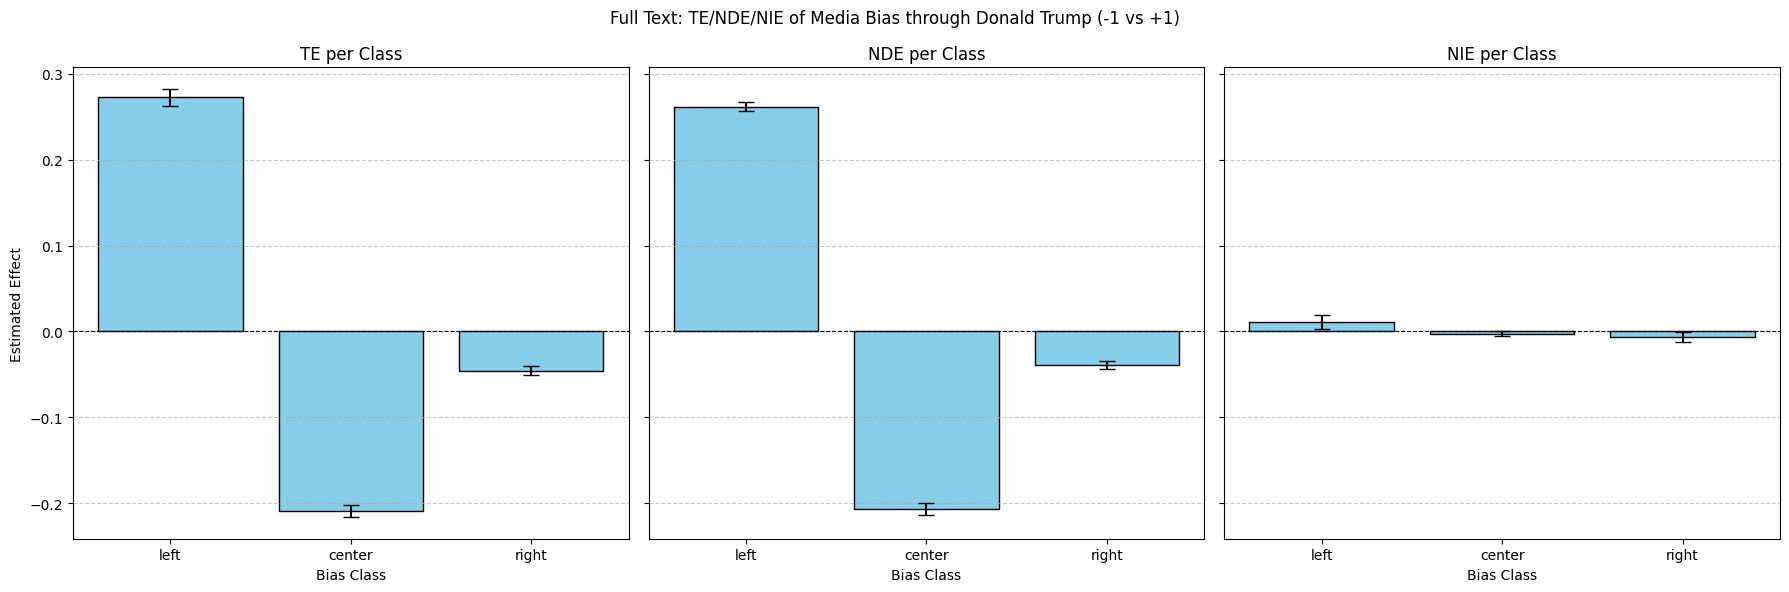

In [231]:
plot_te_nde_nie_with_ci(result_df, "Media Bias", "Donald Trump", -1, 1)